In [1]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np

from valleyfloor.process_topography import process_topography
from valleyfloor.utils import setup_wbt

logger.enable("valleyfloor")

In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

In [4]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)
aligned_flowlines = gpd.GeoSeries(aligned_flowlines['geometry'].values, index=aligned_flowlines['Stream_ID'])

2024-10-11 18:14:32.826 | INFO     | valleyfloor.process_topography:process_topography:36 - process topography
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-hCrF487D-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [5]:
from slopes.subbasins import label_subbasins
from slopes.hillslopes import label_hillslopes

In [6]:
subbasins = label_subbasins(dataset['flow_dir'], dataset['flow_acc'], dataset['flowpaths'], wbt)

In [7]:
hillslopes = label_hillslopes(dataset['flowpaths'], dataset['flow_dir'], subbasins, wbt)

In [8]:
dataset['hillslope'] = hillslopes
dataset['subbasins'] = subbasins

In [10]:
from slopes.network_xsections import network_xsections, observe_values

In [11]:
xs = network_xsections(aligned_flowlines, 10, 40, 2, subbasins=subbasins)

In [12]:
xs = observe_values(xs, dataset[['conditioned_dem', 'hand', 'slope', 'curvature', 'hillslope', 'flowpaths']])

In [13]:
xs

,geom,pointID,streamID,xsID,alpha,conditioned_dem,hand,slope,curvature,hillslope,flowpaths
20308,POINT (393697.916 3791067.916),0,1.0,0,-237,962.053223,114.158671,13.505434,0.020138,3.0,NaN
20309,POINT (393699.33 3791069.33),1,1.0,0,-235,961.074524,113.179973,25.926989,0.044993,3.0,NaN
20310,POINT (393700.744 3791070.744),2,1.0,0,-233,960.316589,112.422038,28.941158,0.025338,3.0,NaN
20311,POINT (393702.158 3791072.158),3,1.0,0,-231,958.625793,110.731242,32.505211,0.019083,3.0,NaN
20312,POINT (393703.573 3791073.573),4,1.0,0,-229,957.765625,109.871074,34.459190,0.016875,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
111549,POINT (394198.708 3790646.299),112191,14.0,17,99,851.249756,52.406128,42.288010,-0.006328,3.0,NaN
111551,POINT (394200.122 3790647.713),112192,14.0,17,101,853.341064,54.497437,42.102978,0.007257,3.0,NaN
111553,POINT (394201.537 3790649.127),112193,14.0,17,103,855.038818,56.195190,40.012913,0.017996,3.0,NaN
111555,POINT (394202.951 3790650.542),112194,14.0,17,105,856.148010,57.304382,37.098660,0.012031,3.0,NaN


In [14]:
stream_xs = xs.loc[xs['streamID'] == 6]
sample = stream_xs.loc[stream_xs['xsID'] == 9].sort_values('alpha')
mid = sample.loc[np.isfinite(sample['flowpaths']), 'alpha']

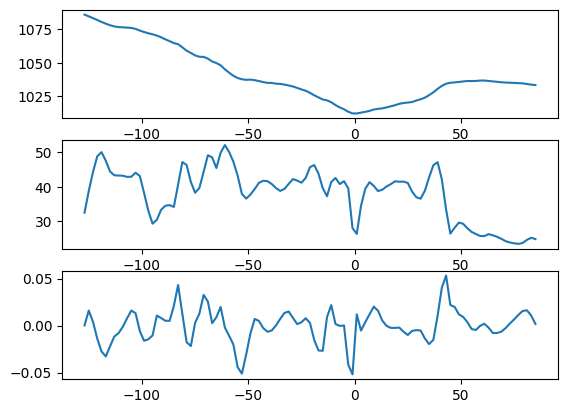

In [15]:
fig, axes = plt.subplots(3)
axes[0].plot(sample['alpha'], sample['conditioned_dem'])
axes[1].plot(sample['alpha'], sample['slope'])
axes[2].plot(sample['alpha'], sample['curvature'])

In [17]:
from slopes.segment_profile import *

In [21]:
labels, bps = mean_shift(sample['slope'].values)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

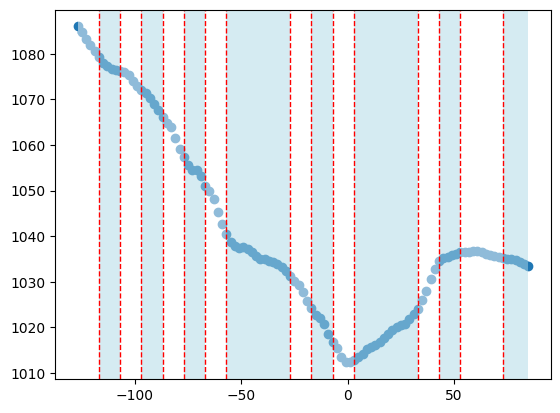

In [31]:
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

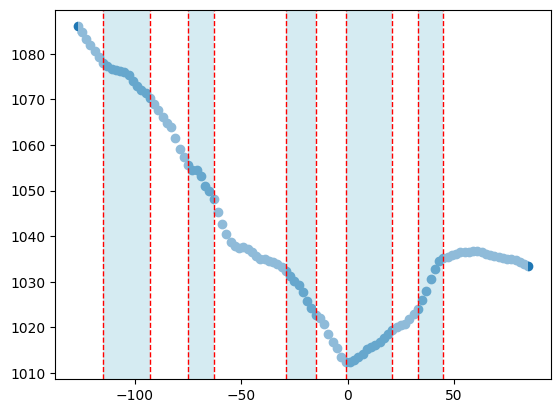

In [37]:
labels, bps = elevation_simplification(sample['conditioned_dem'], sample['alpha'], epsilon=0.5)
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

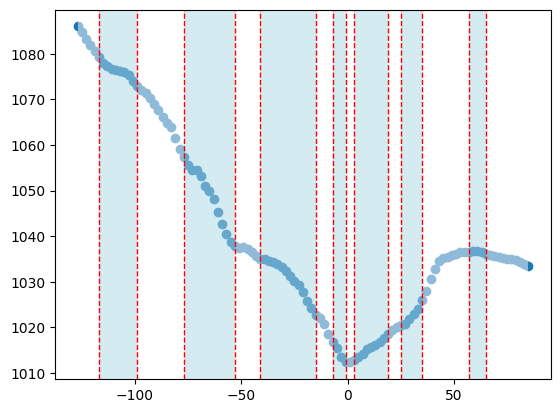

In [41]:
labels, bps = profile_curvature_peaks(-sample['curvature'].values)
plot_segments(sample['alpha'], sample['conditioned_dem'], labels, bps)

In [ ]:
# where does the mean slope from thalweg to breakpoint exceed 10 degrees? -- one way of handling terraces